In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from torch import log
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

from dataloader.cobot_loader import load_cobot_data, Cdata_generator, CConfig

from models.DDNet_Original import DDNet_Original as DDNet
from utils import makedir
import sys
import time
import numpy as np
import logging

import clip
from KLLoss import KLLoss, CELoss
import warnings
import argparse
warnings.filterwarnings("ignore")
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/dev/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [68]:
device = torch.device("cuda")
kwargs = {'batch_size': 64}
kwargs.update({'num_workers': 12,
                    'pin_memory': True,
                    'shuffle': True},)

Config = CConfig()
data_generator = Cdata_generator
load_data = load_cobot_data
clc_num = Config.clc_num


# 

# In[11]:


C = Config




exp = '1706296036_RN50x4'
run_name = 'RN50x4'
import os

Net = DDNet(C.frame_l, C.joint_n, C.joint_d,
            C.feat_d, 64, clc_num, run_name)
model_RN = Net.to(device)


model_RN.load_state_dict(torch.load(f'/home/dev/DD-Net-Pytorch/experiments/{exp}/model.pt'))
model_RN.eval()

exp = 'only_ddnet_new'
run_name = 'ddnet'
Net = DDNet(C.frame_l, C.joint_n, C.joint_d,
            C.feat_d, 64, clc_num, run_name)
import os

model = Net.to(device)
model.load_state_dict(torch.load(f'/home/dev/DD-Net-Pytorch/experiments/{exp}/model.pt'))
model.eval()

DDNet_Original(
  (jcd_conv1): Sequential(
    (0): c1D(
      (conv1): Conv1d(1128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): spatialDropout1D(
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
  )
  (jcd_conv2): Sequential(
    (0): c1D(
      (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): spatialDropout1D(
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
  )
  (jcd_conv3): c1D(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (jcd_pool): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): spatialDropout1D(
      (dropout): Dropout2d(p=0.1, inplace=False)

In [56]:
C = Config
Train, Test, le = load_cobot_data()

X_0_t, X_1_t, Y_t = data_generator(Test, C, le)
X_0_t = torch.from_numpy(X_0_t).type('torch.FloatTensor')
X_1_t = torch.from_numpy(X_1_t).type('torch.FloatTensor')
Y_t = torch.from_numpy(Y_t).type('torch.LongTensor')

testset = torch.utils.data.TensorDataset(X_0_t, X_1_t, Y_t)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=16)

Done


100%|██████████| 1561/1561 [00:52<00:00, 29.96it/s]


In [69]:
def predict (model, device, test_loader):
    model.eval()
    pred_list = list()
    feature_list = list()
    with torch.no_grad():
        for _, (data1, data2, target) in enumerate(tqdm(test_loader)):
            M, P, target = data1.to(device), data2.to(device), target.to(device)
            output, _features = model(M, P)
            feature_list.append(_features.cpu().detach().numpy())
            pred = output.argmax(dim=1, keepdim=True)
            # to list
            pred = pred.cpu().numpy().tolist()
            pred_list.extend(pred)
    return pred_list, feature_list 

In [98]:
pred_results, feature_list = predict(model, device, test_loader)
pred_results_RN, feature_list_RN = predict(model_RN, device, test_loader)

100%|██████████| 98/98 [00:00<00:00, 116.37it/s]


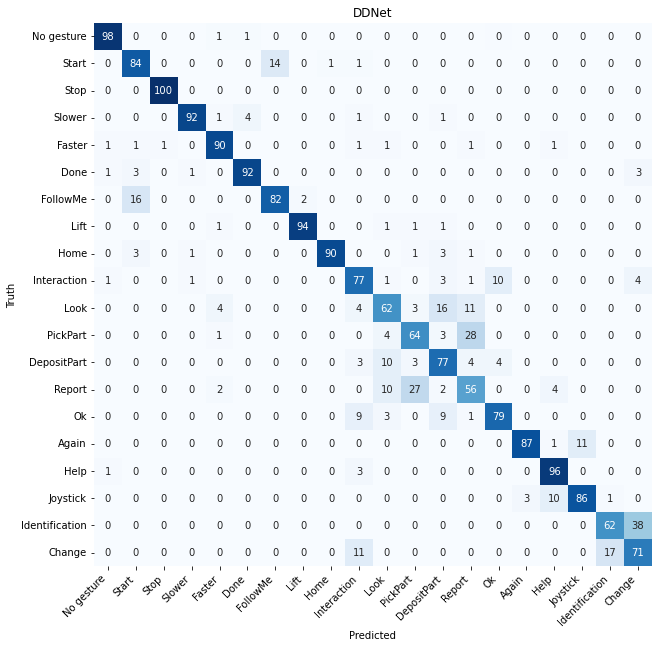

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns# Generate confusion matrix
cm = confusion_matrix(Y_t, pred_results, normalize='true')

# Convert to percentages
cm_percentage = cm * 100
# Plot confusion matrix
labels_txt = ['No gesture','Start', 'Stop', 'Slower', 'Faster', 'Done', 'FollowMe', 'Lift', 'Home', 'Interaction', 'Look', 'PickPart', 'DepositPart', 'Report', 'Ok', 'Again', 'Help', 'Joystick', 'Identification', 'Change']
plt.figure(figsize=(10,10))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt='.0f',cbar=False,xticklabels=labels_txt, yticklabels=labels_txt)
plt.xlabel('Predicted') 
plt.ylabel('Truth')
plt.title("DDNet")
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

#plt.show()
plt.savefig("cfs_DDNet.eps")

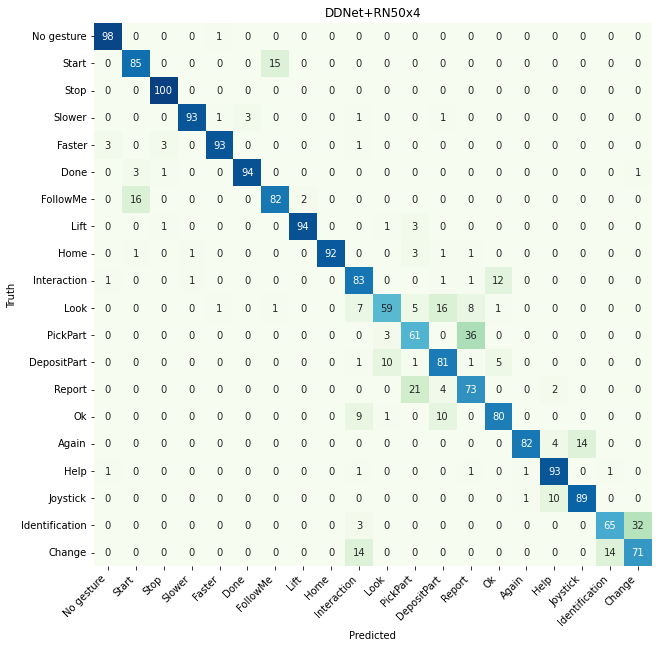

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns# Generate confusion matrix

cm = confusion_matrix(Y_t, pred_results_RN, normalize='true')
labels_txt = ['No gesture','Start', 'Stop', 'Slower', 'Faster', 'Done', 'FollowMe', 'Lift', 'Home', 'Interaction', 'Look', 'PickPart', 'DepositPart', 'Report', 'Ok', 'Again', 'Help', 'Joystick', 'Identification', 'Change']

# Convert to percentages
cm_percentage = cm * 100
# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_percentage, annot=True, cmap='GnBu', fmt='.0f',cbar=False,xticklabels=labels_txt, yticklabels=labels_txt)
plt.title("DDNet+RN50x4")
plt.xlabel('Predicted') 
plt.ylabel('Truth')
plt.xlabel('Predicted') 
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

#plt.show()
plt.savefig("cfs_DDNet_rn50.eps")

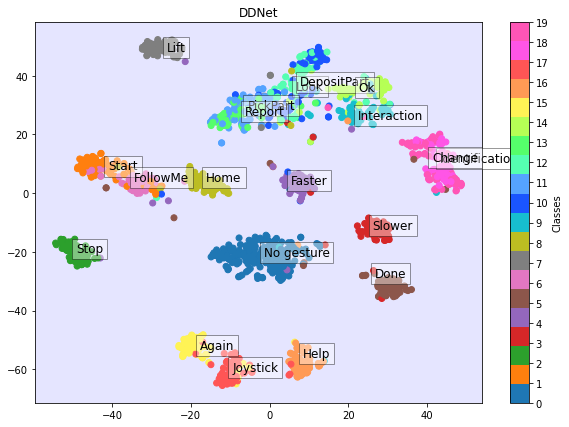

In [101]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.colors import ListedColormap
vectors = []
for f in feature_list:
    for _ in range(f.shape[0]):
        vectors.append(f[_])
vectors = np.stack(vectors, axis=0)


# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors)
# Define your list of labels
labels = Y_t

# Define a list of 20 different color codes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#1a55FF', '#55a3FF', '#55FFB1', '#55FF6B', '#B6FF55', '#FFF355', '#FF9A55', '#FF5555', '#FF55E6', '#FF55B6']

# Create a colormap
colormap = ListedColormap(colors)
# Plot the resulting 2D points
plt.figure(figsize=(10, 7))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap=colormap)
# Add class names to the centers of the clusters
for i in range(20):
    centroid = np.mean(vectors_2d[labels == i], axis=0)
    plt.text(centroid[0], centroid[1], labels_txt[i], fontsize=12, bbox=dict(facecolor='white', alpha=0.4))

# Add a color bar
cbar = plt.colorbar(scatter, ticks=range(20))
cbar.set_label('Classes')
plt.title("DDNet")
plt.gca().set_facecolor((0, 0, 1, 0.1)) 
plt.savefig("tsne_DDNet.png")


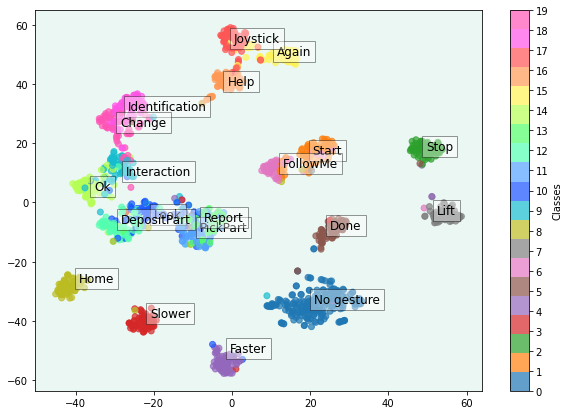

In [102]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.colors import ListedColormap
vectors = []
for f in feature_list_RN:
    for _ in range(f.shape[0]):
        vectors.append(f[_])
vectors = np.stack(vectors, axis=0)


# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors)
# Define your list of labels
labels = Y_t

# Define a list of 20 different color codes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#1a55FF', '#55a3FF', '#55FFB1', '#55FF6B', '#B6FF55', '#FFF355', '#FF9A55', '#FF5555', '#FF55E6', '#FF55B6']

# Create a colormap
colormap = ListedColormap(colors)
# Plot the resulting 2D points
plt.figure(figsize=(10, 7))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap=colormap, alpha=0.7)
# Add class names to the centers of the clusters
for i in range(20):
    centroid = np.mean(vectors_2d[labels == i], axis=0)
    plt.text(centroid[0], centroid[1], labels_txt[i], fontsize=12, bbox=dict(facecolor='white', alpha=0.4))

# Add a color bar
cbar = plt.colorbar(scatter, ticks=range(20))
cbar.set_label('Classes')
plt.gca().set_facecolor((0.24, 0.71, 0.54, 0.1))
plt.savefig("tsne_DDNet_rn50.png")

In [103]:
vectors.shape[0]

1561